# 📦 Importing Packages

In [1]:
# 📦 Standard Library
import os
import re
import time
import random
from collections import defaultdict
from typing import Iterable, List

# 📊 Data & Numerics
import numpy as np
import pandas as pd

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🤖 ML / NLP
import torch
import spacy
import emoji
from nltk.stem import SnowballStemmer

# 🧪 Scikit-learn
from sklearn.model_selection import (
    GroupShuffleSplit, GroupKFold, StratifiedKFold,
    GridSearchCV, cross_val_score
)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 🧭 Utils
from tqdm import tqdm

# ⚙️ Global Settings

In [2]:
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")

DATASET_TYPE = "toxicity"
DATASET_PATH = os.path.join(".", "out", "datasets", f"cipv-chats-{DATASET_TYPE}", "chats")

GLOBAL_SEED = 42

TASK = 'binary'  # else 'multiclass'

if TASK == 'binary':
    POLARITY_BINS = [-1.01, 0.35, 1.01]
    POLARITY_LABELS = [0, 1]  # 0: Toxic, 1: Healthy
    TARGET_NAMES = ['Toxic', 'Healthy']
else:
    POLARITY_BINS = [-1.01, -0.35, 0.35, 1.01]
    POLARITY_LABELS = [0, 1, 2]
    TARGET_NAMES = ['Toxic', 'Neutral', 'Healthy']

MSGS_REGEX = re.compile(r"(?P<message>\(?(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d)\)? ?\|? ?(?P<name_content>(?P<name>.+):\n?\s?(?P<content>.+))\n?\s?Polarity: (?P<polarity>(?:-?|\+?)\d\.?\d?\d?))")

OUT_DIR = os.path.join(".", "out", "models", f"{DATASET_TYPE}", f"entire-chat-{TASK}-classification", f"{timestamp}")

# 🛠️ Utility Functions

In [3]:
def set_global_seed(seed=GLOBAL_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(GLOBAL_SEED)

def plot_polarity_distribution(df: pd.DataFrame) -> None:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    df["min_avg_polarity"].hist(bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    plt.axvline(x=0, color='orange', linestyle='--', alpha=0.7, label='Neutral Polarity')
    plt.axvline(x=-0.35, color='red', linestyle='--', alpha=0.7, label='Toxic Treshold')
    plt.axvline(x=0.35, color='green', linestyle='--', alpha=0.7, label='Healthy Treshold')
    plt.xlabel('Min Average Polarity')
    plt.ylabel('Frequency')
    plt.title('Min Average Polarity Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    label_counts = df["label"].value_counts().sort_index()
    colors = ['red', 'orange', 'green']
    bars = plt.bar(range(len(label_counts)), label_counts.values, 
                   color=colors, alpha=0.7, edgecolor='black')
    plt.xticks(range(len(label_counts)), TARGET_NAMES)
    plt.ylabel('Count')
    plt.title('Labels Distribution')
    plt.grid(True, alpha=0.3, axis='y')
    
    for bar, count in zip(bars, label_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_heatmap(y_true, y_pred, target_names, title="Confusion Matrix", save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=target_names, yticklabels=target_names,
        cbar_kws={'label': 'Count'}, annot_kws={'size': 12}
    )
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title, fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# 📂 Dataset Loading

📂 Loading Dataset from: .\out\datasets\cipv-chats-toxicity\chats


📂 Loading Dataset: 100%|██████████| 11/11 [00:28<00:00,  2.55s/it]


   ✅ Loaded Chats: 3087
   ❌ Skipped Chats: 70

🔍 NaN Analysis: 0 samples with label NaN


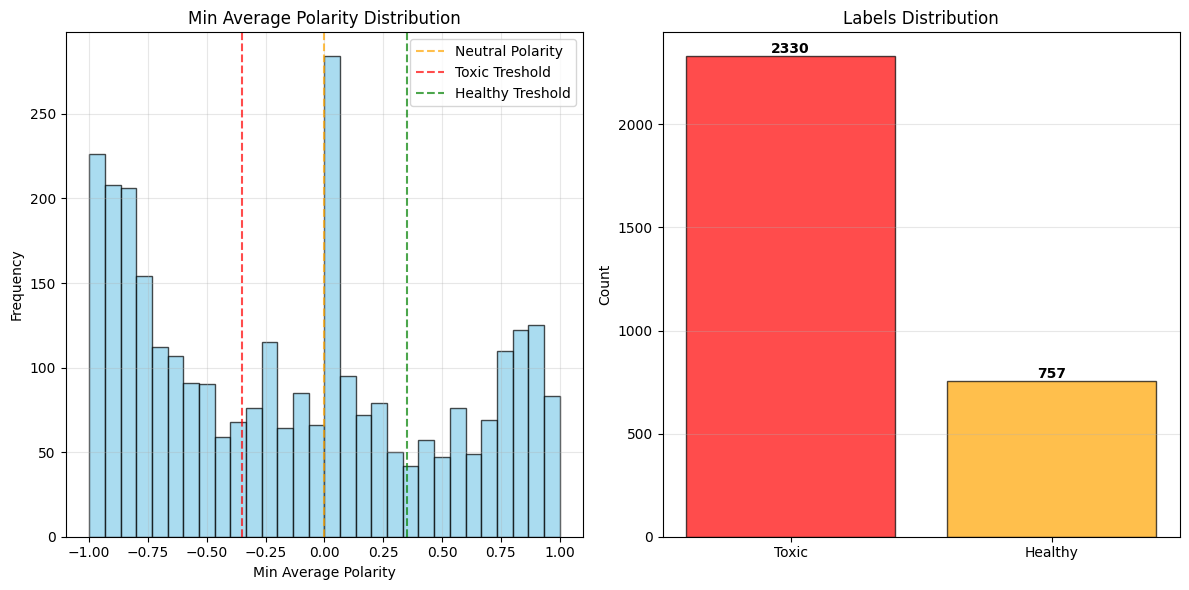

In [4]:
def group_polarities_by_user(messages) -> dict:
    person_polarities = defaultdict(list)
    for msg in messages:
        name = msg.group("name").strip()
        polarity = float(msg.group("polarity").strip())
        person_polarities[name].append(polarity)
    return dict(person_polarities)

def extract_chat_data(dataset_path: str) -> dict:
    dataset = {
        "chat_text": [],
        "min_avg_polarity": [],
        "user_ids": []
    }
    skipped = 0
    dirs = os.listdir(dataset_path)
    for directory in tqdm(dirs, desc="📂 Loading Dataset"):
        directory_path = os.path.join(dataset_path, directory)
        couple_dirs = os.listdir(directory_path)
        for couple_dir in couple_dirs:
            couple_dir_path = os.path.join(directory_path, couple_dir)
            files = os.listdir(couple_dir_path)
            for file in files:
                file_path = os.path.join(couple_dir_path, file)
                with open(file_path, "r", encoding="utf-8") as f:
                    chat = f.read()
                    messages = list(MSGS_REGEX.finditer(chat))
                    all_messages = [msg.group("content").strip() for msg in messages]
                    if len(messages) == 0:
                        skipped += 1
                        continue
                    
                    # 📊 RACCOLTA POLARITÀ PER PERSONA
                    person_polarities = group_polarities_by_user(messages)
                    if len(person_polarities) != 2:
                        skipped += 1
                        continue
                    person_avg_polarities = [
                        sum(polarities) / len(polarities)
                        for polarities in person_polarities.values()
                        if polarities
                    ]
                    min_avg_polarity = min(person_avg_polarities)

                    dataset["chat_text"].append('\n'.join(all_messages))
                    dataset["min_avg_polarity"].append(min_avg_polarity)
                    dataset["user_ids"].append(couple_dir)
    return dataset, skipped

print(f"📂 Loading Dataset from: {DATASET_PATH}")
dataset, skipped = extract_chat_data(DATASET_PATH)
print(f"   ✅ Loaded Chats: {len(dataset['chat_text'])}")
print(f"   ❌ Skipped Chats: {skipped}")

df = pd.DataFrame(dataset)
df["label"] = pd.cut(df["min_avg_polarity"], bins=POLARITY_BINS, labels=POLARITY_LABELS)

nan = df[df['label'].isna()]
print(f"\n🔍 NaN Analysis: {len(nan)} samples with label NaN")
if len(nan) > 0:
    print("Samples with NaN:")
    print(nan[['min_avg_polarity', 'label']].head())

df = df.dropna(subset=['label'])

plot_polarity_distribution(df)

# 📂 Dataset Splitting

In [5]:
gss_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=GLOBAL_SEED)
train_val_idx, test_idx = next(gss_test.split(
    X=df['chat_text'], 
    y=df['label'], 
    groups=df['user_ids']
))

test_df = df.iloc[test_idx].copy()
train_val_df = df.iloc[train_val_idx].copy()

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=GLOBAL_SEED)
train_idx, val_idx = next(gss_val.split(
    X=train_val_df['chat_text'], 
    y=train_val_df['label'], 
    groups=train_val_df['user_ids']
))

val_df = train_val_df.iloc[val_idx].copy()
train_df = train_val_df.iloc[train_idx].copy()

print(f"Train/Eval Set Size: {len(train_val_df)} ({len(train_val_df) / len(df) * 100:.2f}%)")
print(f"Couples in Train/Eval Set: {train_val_df['user_ids'].nunique()}")

print(f"\nTest Set Size: {len(test_df)} ({len(test_df) / len(df) * 100:.2f}%)")
print(f"Couples in Test Set: {test_df['user_ids'].nunique()}")

print(f"\nTrain Set Size: {len(train_df)} ({len(train_df) / len(df) * 100:.2f}%)")
print(f"Couples in Train Set: {train_df['user_ids'].nunique()}")

print(f"\nValidation Set Size: {len(val_df)} ({len(val_df) / len(df) * 100:.2f}%)")
print(f"Couples in Validation Set: {val_df['user_ids'].nunique()}")

Train/Eval Set Size: 2462 (79.75%)
Couples in Train/Eval Set: 88

Test Set Size: 625 (20.25%)
Couples in Test Set: 22

Train Set Size: 2001 (64.82%)
Couples in Train Set: 70

Validation Set Size: 461 (14.93%)
Couples in Validation Set: 18


# 📄​ Methodology

In [6]:
def do_experiment(X_train, y_train, X_test, y_test, groups, pipeline, p_grid, save_path):
    grid_search = GridSearchCV(
        pipeline,  p_grid,
        cv=GroupKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED),
        scoring='f1_weighted',
        n_jobs=1, verbose=2,
        # return_train_score=True,
    )

    grid_search.fit(X_train, y_train, groups=groups)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results.to_csv(os.path.join(save_path, "cv_results.csv"), index=False)

    best_params = grid_search.best_params_
    best_pipeline = pipeline.set_params(**best_params)

    best_pipeline.fit(X_train, y_train)

    y_pred = best_pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=TARGET_NAMES) # , output_dict=True
    with open(os.path.join(save_path, "classification_report.txt"), "w") as f:
        f.write(report)
    print(report)
    # report_df = pd.DataFrame(report).transpose()
    # report_df.to_csv(os.path.join(save_path, "classification_report.csv"), index=False)

    # plot and save confusion matrix
    plot_confusion_matrix_heatmap(
        y_test, y_pred, 
        target_names=TARGET_NAMES, 
        title=f"Confusion Matrix - {pipeline.steps[-1][1].__class__.__name__}",
        save_path=os.path.join(save_path, "confusion_matrix.png")
    )

In [7]:
from sklearn.model_selection import cross_validate

def do_nested_cv(X_train, y_train, X_test, y_test, groups, pipeline, p_grid, save_path):
    save_path = os.path.join(save_path, pipeline.steps[-1][1].__class__.__name__)
    os.makedirs(save_path, exist_ok=True)

    inner_cv = GroupKFold(n_splits=3, shuffle=True, random_state=GLOBAL_SEED)
    grid_search = GridSearchCV(
        pipeline, param_grid=p_grid, cv=inner_cv,
        scoring='f1_weighted'
    )

    outer_cv = GroupKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)
    cv_results = cross_val_score( # only a metric
        grid_search, X_train,
        y_train, cv=outer_cv,
        scoring='f1_weighted',
        groups=groups,
        n_jobs=1, verbose=2
    )

    # cv_results = cross_validate( # also multiple metrics
    #     grid_search, X_train,
    #     y_train, cv=outer_cv,
    #     scoring='f1_weighted',
    #     groups=groups,
    #     n_jobs=1, verbose=2
    # )


# ✨​ Pre-Processing

## Classes

In [8]:
class SpacyPosNerPreprocessorWithStemming:

    def __init__(
            self, nlp: spacy.language.Language,
            stemmer,
            pos_whitelist: Iterable[str],
            ner_to_replace: Iterable[str]
        ):
        self.nlp = nlp
        self.pos_whitelist = pos_whitelist
        self.ner_to_replace = ner_to_replace
        self.stemmer = stemmer

    def __call__(self, text: str) -> List[str]:

        doc = self.nlp(text)

        ent_map = {}
        for ent in doc.ents:
            if ent.label_ in self.ner_to_replace:
                for i in range(ent.start, ent.end + 1):
                    ent_map[i] = ent.label_

        tokens = []
        for i, token in enumerate(doc):
            if token.text in emoji.EMOJI_DATA:
                tokens.append(token.text)
            elif i in ent_map:
                tokens.append(ent_map[i])
            else:
                if token.pos_ in self.pos_whitelist:
                    if token.is_upper:
                        tokens.append(self.stemmer.stem(token.text))
                    else:
                        tokens.append(self.stemmer.stem(token.text).lower())

        return tokens

In [9]:
class SpacyPosNerPreprocessor:

    def __init__(
            self, nlp: spacy.language.Language,
            pos_whitelist: Iterable[str],
            ner_to_replace: Iterable[str]
        ):
        self.nlp = nlp
        self.pos_whitelist = pos_whitelist
        self.ner_to_replace = ner_to_replace

    def __call__(self, text: str) -> List[str]:

        doc = self.nlp(text)

        ent_map = {}
        for ent in doc.ents:
            if ent.label_ in self.ner_to_replace:
                for i in range(ent.start, ent.end + 1):
                    ent_map[i] = ent.label_

        tokens = []
        for i, token in enumerate(doc):
            if token.text in emoji.EMOJI_DATA:
                tokens.append(token.text)
            elif i in ent_map:
                tokens.append(ent_map[i])
            else:
                if token.pos_ in self.pos_whitelist:
                    if token.is_upper:
                        tokens.append(token.lemma_)
                    else:
                        tokens.append(token.lemma_.lower())

        return tokens

## Pre-Process

In [10]:
nlp = spacy.load("it_core_news_sm")
# nlp.disable_pipes(*[name for name in nlp.pipe_names if name != "lemmatizer"])

# preprocessor = SpacyPosNerPreprocessorWithStemming(
#     nlp, SnowballStemmer("italian"),
#     ner_to_replace=['PERSON', 'ORG', 'LOC'],
#     pos_whitelist=['VERB', 'ADJ', 'ADV', 'NOUN', 'INTJ', 'PRON', 'AUX']
# )

preprocessor = SpacyPosNerPreprocessor(
    nlp, ner_to_replace=['PERSON', 'ORG', 'LOC'],
    pos_whitelist=['VERB', 'ADJ', 'ADV', 'NOUN', 'INTJ', 'PRON', 'AUX']
)

OUT_DIR += f"-{preprocessor.__class__.__name__}"
os.makedirs(OUT_DIR, exist_ok=True)

X_train = train_val_df['chat_text'].map(lambda x: preprocessor(x))
X_test = test_df['chat_text'].map(lambda x: preprocessor(x))

pp_param_grid = {
    'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
    'vectorizer__min_df': [3, 8, 20],
    'vectorizer__max_df': [0.9, 0.95, 0.99],
}

# 🧪 Naive Bayes

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.3s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.3s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.3s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.3s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.3s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3); total time=   0.7s
[CV] END classifier__alpha=0.1, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3); total time=   0.6s
[CV] END classifier__alpha=0.1, ve

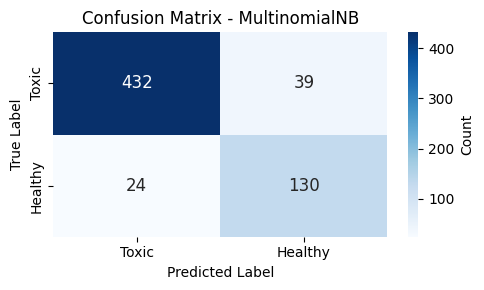

In [11]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(
        tokenizer=lambda x: x, lowercase=False,
        token_pattern=None, preprocessor=None
    )),
    ("classifier", MultinomialNB())
])

param_grid = {**pp_param_grid, **{
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
}}

save_path = os.path.join(OUT_DIR, pipeline.steps[-1][1].__class__.__name__)
os.makedirs(save_path, exist_ok=True)

do_experiment(
    X_train, train_val_df['label'], 
    X_test, test_df['label'], 
    train_val_df['user_ids'], 
    pipeline, param_grid, 
    save_path
)

# 🧪 Logistic Regression

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END classifier__C=0.1, classifier__max_iter=1000, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.4s
[CV] END classifier__C=0.1, classifier__max_iter=1000, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.4s
[CV] END classifier__C=0.1, classifier__max_iter=1000, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.4s
[CV] END classifier__C=0.1, classifier__max_iter=1000, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.3s
[CV] END classifier__C=0.1, classifier__max_iter=1000, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   0.4s
[CV] END classifier__C=0.1, classifier__max_iter=1000, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3); total time=   0.7s
[CV] END classifier__C=0.

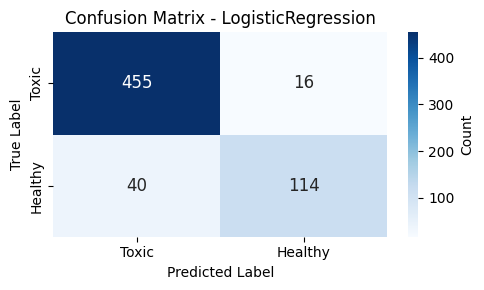

In [12]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(
        tokenizer=lambda x: x, lowercase=False,
        token_pattern=None, preprocessor=None
    )),
    ("classifier", LogisticRegression(
        random_state=GLOBAL_SEED, penalty='l2', 
        solver='lbfgs'
    ))
])

param_grid = {**pp_param_grid, **{
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__max_iter': [1000, 2000]
}}

save_path = os.path.join(OUT_DIR, pipeline.steps[-1][1].__class__.__name__)
os.makedirs(save_path, exist_ok=True)

do_experiment(
    X_train, train_val_df['label'], 
    X_test, test_df['label'], 
    train_val_df['user_ids'], 
    pipeline, param_grid, 
    save_path
)

# 🧪 SVC

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   4.5s
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   4.1s
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   4.5s
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   4.5s
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   4.5s
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3); total time=   5.4s
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3); total time=   4.8s
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3); total time=   5.2s
[CV] END vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3); tot

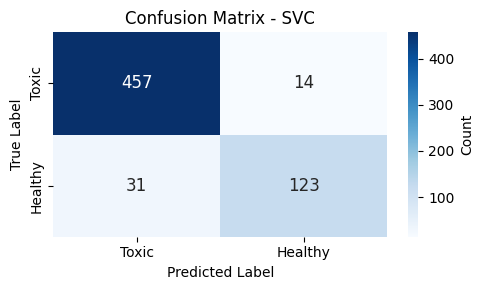

In [13]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(
        tokenizer=lambda x: x, lowercase=False,
        token_pattern=None, preprocessor=None
    )),
    ("classifier", SVC(
        random_state=GLOBAL_SEED,
        gamma='scale', kernel='rbf',
        class_weight='balanced', C=1.0,
    ))
])

param_grid = {**pp_param_grid, **{
    # 'classifier__C': [0.1, 1.0, 10.0],
    # 'classifier__kernel': ['linear', 'rbf'],
    # 'classifier__gamma': ['scale', 'auto']
}}

save_path = os.path.join(OUT_DIR, pipeline.steps[-1][1].__class__.__name__)
os.makedirs(save_path, exist_ok=True)

do_experiment(
    X_train, train_val_df['label'], 
    X_test, test_df['label'], 
    train_val_df['user_ids'], 
    pipeline, param_grid, save_path
)